# PAM-Basisbandübertragung für BPSK

Dieses Notebook dient dazu, das Verständnis für PAM-Übertragung im Allgmeinen zu erhöhen. Zur Vereinfachung wird eine BPSK-Übertragung im Basisband besprochen. Viele der Sachverhalte gelten aber unverändert auch für höherstufige Modulationsverfahren und Bandpassübertragung.

![BPSK-System](figures/PAM_BPSK/System_Blockdiagramm.png)

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

pi = np.math.pi
%matplotlib inline
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
# globale Definitionen
add_noise = True
SNR = -20 # in dB: SNR auf dem Kanal (input SNR)

N = 400 # Anzahl der Symbole (kann erhoeht werden)
Ts = 4 # Symbolabstand
samples_per_second = 200 # zeitl. Aufloesung
samples_per_symbol = samples_per_second*Ts
delta_t = 1/samples_per_second # wichtig fuer Faltungen

t = np.arange(-10*Ts, 10*Ts, delta_t)

#### Hinweis zur Simulation:
Ein SNR auf dem Kanal ergibt bei weißem, zeitkontinuierlichen Rauschen eigentlich keinen Sinn, weil die Rauschleistung dann unendlich groß ist. Dies ist im Abschnitt zum Kanal genauer erklärt.

Die Größe $\Delta t$ bzw. `delta_t` in Python ist notwendig, weil im Rechner nur zeitdiskrete Signale dargestellt werden können.

Das Rauschen kann durch die boolsche Variable `add_noise` ein- und ausgeschaltet werden. Beide Fälle sollten einmal durchprobiert werden, denn insbesondere die Signalform des Entscheidungssignals (Vergleich mit der Gesamtpulsform!) und das Augendiagramm sind auch im störungsfreien Fall sehr wichtig.

## Definition des Sende- und des Empfangsfilters

Durch die Einführung eines abweichenden Abtastzeitpunktes $t_0 \neq 0$ lässt sich eine Verzögerung einbauen, die so gewählt werden kann, dass Sende- und Empfangsfilter kausale Systeme sind.

Das Sendefilter ist hier als Rechteck gewählt. Dies ist anschaulich, aber idealisiert. In der Praxis treten echte Rechteckpulse fast nie auf. Bei Bandpassübertragung werden Raised-Cosine-Pulse gewählt, weil die zur verfügung stehende Bandbreite stark begrenzt ist.
Bei **Basisbandübertragung über eine Leitung** (z.B. Ethernet, RS-232) werden approximierte Rechteckpulse verwendet, weil zwar eine große Bandbreite zur Verfügung steht, die durch die verarbeitende Elektronik jedoch auch gewissen Grenzen unterliegt.

Die Übertragung über optische Wellenleiter lässt sich eher als Bandpassübertragung verstehen, weil die Amplitude der als Trägersignal dienenden Lichtwelle moduliert wird.

In [3]:
# Sende- und Empfangsfilter (Matched Filter)

# Beispielsweise Loesung von Aufgabe 14.6 
# (darum BPSK: Binary Phase Shift Keying!): 
#send_filter = np.sin(pi*t/Ts)*(np.absolute(t) < Ts/2)

# NRZ-Puls: (Rechteck-Puls mit Symboldauer als Breite)
send_filter = (np.absolute(t) < Ts/2)

Eg = np.sum(np.absolute(send_filter)**2)*delta_t
var_A = 1
Es = Eg*var_A
print('Es = {:1.2f}'.format(Es))
# Matched-Filter:
receive_filter = np.flipud(send_filter)/np.sqrt(Eg)

Es = 4.00


#### Hinweis zu Leistungs- und Energiebeziehungen
Wie später angegeben, ist die Kanalimpulsantwort $b(t) = \delta(t)$ hier ein Diracimpuls. Deswegen gilt **hier**: $E_h = E_g$.
Die Momentan-Sendeleistung ist abhängig von der Energie des Sendepulses $E_g$ und vom aktuellen Symbol $A(k)$. Dies ist wichtig, um minimale und maximale Signalleistung zu identifizieren. Weil die Symbolsequenz ein Zufallsprozess ist, sind aber vor allem Scharmittelungen der Leistung interessant (also die zweiten statistischen Momente des Zufallsprozesses).

Wird wie hier bei BPSK das Symbolalphabel $\Omega_A = \left\{{-}1, 1\right\}$ gewählt, ergibt sich auch $\sigma_A^2 = 1$ (egal, wie wahrscheinlich die Symbole sind). Dies ist wichtig für die mittlere Sendeleistung $P_s = \frac{E_\mathrm{s}}{T_\mathrm{s}}$, die proportional zur mittleren Symbolenergie $E_\mathrm{s} = E_g \sigma_A^2$ im Sendesignal ist.

Durch Wahl der Symbole und des Sendefilters lässt sich also die Sendeleistung beeinflussen.

In der Praxis würde dies durch einen Sendeverstärker mit Verstärkungsfaktor $a$ durchgefährt werden. Ist dieser linear, kann dessen Effekt aber vollständig durch die Symbole beschrieben werden. Dann gilt bei BPSK 
$\Omega_A = \left\{{-}a, a\right\}$ und $\sigma_A^2 = a^2$.

### Plot der Form des Gesamtpulses p(t)
Mit diesem Plot kann im Zeitbereich beurteilt werden, ob das Nyquistkriterium erfüllt ist.
Dazu muss gelten:

\begin{align}
    p(k T_\mathrm{s}) =  g(t) \ast b(t) \ast f(t)|_{t=kT_\mathrm{s}} \overset{!}{=} C \gamma(k-K)
\end{align}

Erlaubt sind also Skalierungen und Verzögerungen, **jedoch darf jedes Symbol nur einen einzigen Abtastwert im Empfänger beeinflussen**. Zu beachten ist außerdem, dass **immer der Gesamtpuls beurteilt werden muss**!

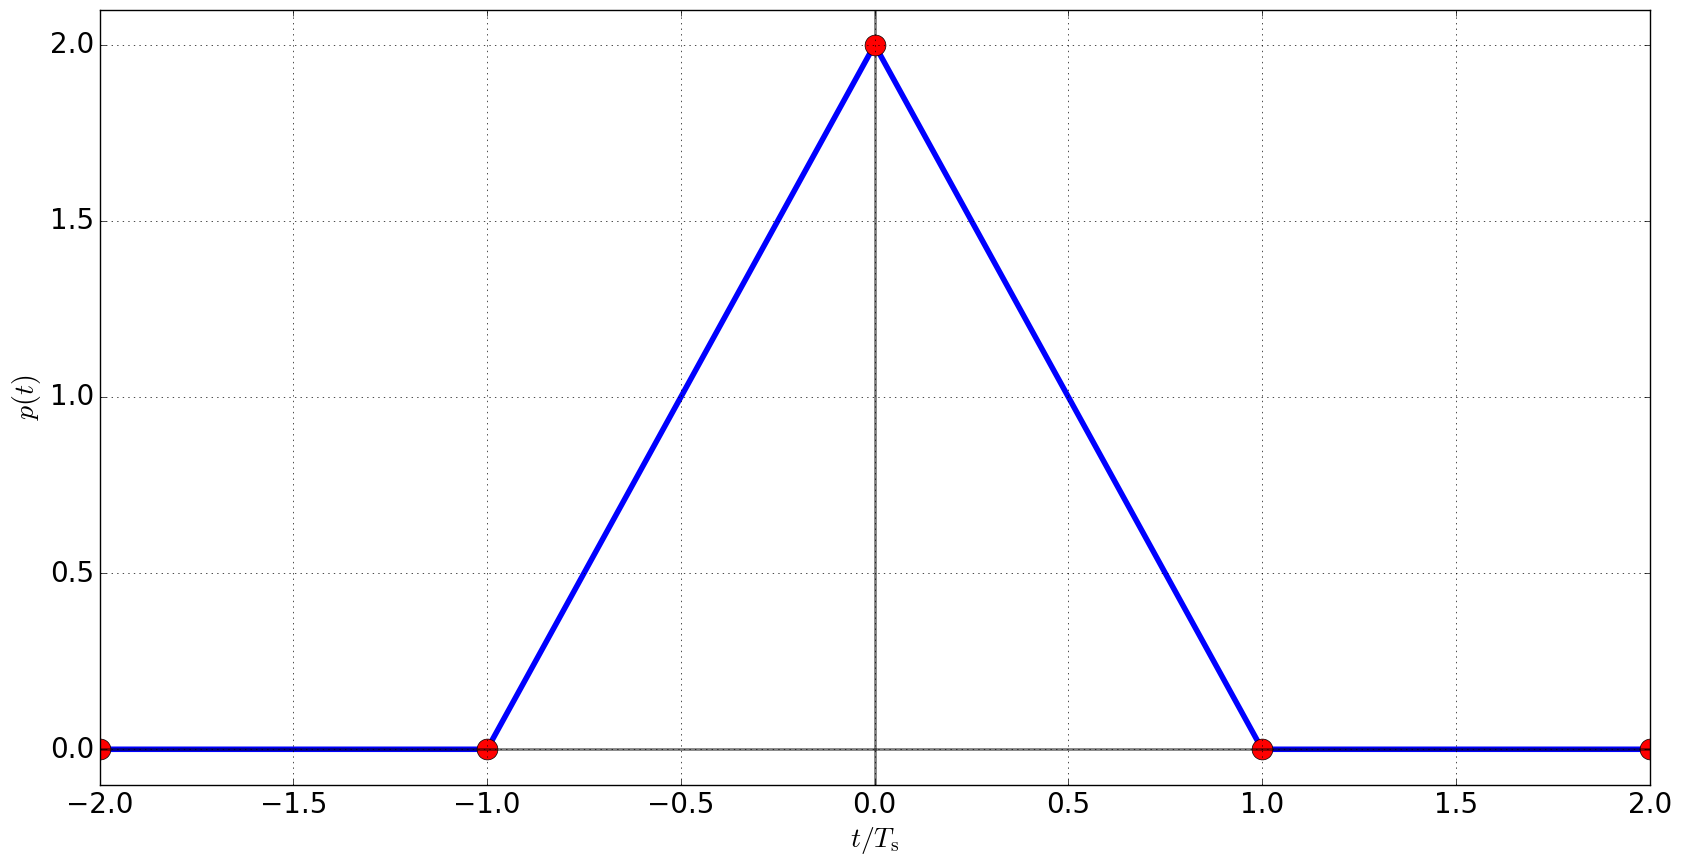

In [4]:
# im Zeitbereich und fuer Kanal mit Dirac-Impulsantwort
complete_pulse = np.convolve(send_filter, receive_filter, 'same')*delta_t
plt.axvline(c='k', lw=2, alpha=0.5)
plt.plot(t/Ts, complete_pulse, lw=4)
plt.plot(t[::samples_per_symbol]/Ts,
         complete_pulse[::samples_per_symbol], 'ro', markersize=15)
plt.axhline(c='k', lw=2, alpha=0.5)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$p(t)$')
plt.xlim((-2, 2))
plt.ylim((-0.1, 2.1))
plt.grid()

Der vorgegebene Rechteck-Sendepuls führt bei Matched Filterung zu einem Dreieck als Gesamtpuls, welches das erste Nyquistkriterium gut sichtbar erfüllt.

#### Hinweis zur Simulation: 
Die diskrete Faltung ist eine Summe. Die kontinulierliche Faltung ist ein Integral und kann deshalb im Rechner durch eine diskrete Faltung nur approximiert werden. Um passende Werte für die kontinuierliche Faltung zu erhalten, muss mit dem Abstand der Zeitpunkte skaliert werden:

\begin{align}
    z(t) = \int_{-\infty}^{\infty} x(\tau) y(t - \tau) \mathrm{d}\tau \approx  \sum_{m=-M}^{M} x(m \Delta t) y( (k- m) \Delta t) \cdot \Delta t = \tilde{z}(k \Delta t)
\end{align}

## Sender

### Symbolfolge und zugehörige Impulsfolge
Die Symbolfolge wird durch Erzeugung gleichverteilter Zufallszahlen generiert. Die zugehörige Impulsfolge ist die Einbettung des diskreten Signals $A(m)$ im Zeitkontinuierlichen:

\begin{align}
    A_\mathrm{cont}(t) = \sum_{m=-\infty}^{\infty} A(m) \delta(t - m T_\mathrm{s})
\end{align}

Da jeder Kanal mit den unendlich breitbandigen Dirac-Impulsen überfordert würde, müssen andere Pulsformen erzeugt werden. Dies erfolgt durch das Sendefilter.

#### Hinweis zur Simulation:
Der Abstand zwischen den Symbolen muss an die Dauer der Symbole angepasst werden.
Zudem muss jeder (durch die endliche zeitliche Auflösung immer noch diskrete) Impuls mit $\frac{1}{\Delta t}$ skaliert werden, um die gleiche Wirkung wie ein kontinuierlicher Impuls zu haben. Im Grenzfall $\Delta t \rightarrow 0$ würde sich auch der Dirac-Impuls ergeben, aber dies ist im Rechner natürlich nicht möglich.

In [5]:
bit_sequence = np.random.rand(N) > 0.5
symbol_sequence = 2*bit_sequence - 1
impulse_sequence = np.zeros(samples_per_symbol*symbol_sequence.shape[0])
impulse_sequence[::samples_per_symbol] = \
    symbol_sequence/delta_t
send_signal = np.convolve(impulse_sequence, send_filter, 'same')*delta_t

### Plot des Sendesignals

\begin{align}
    s(t) = A_\mathrm{cont}(t) \ast g(t) = \sum_{m=-\infty}^{\infty} A(m) g(t - m T_\mathrm{s})
\end{align}

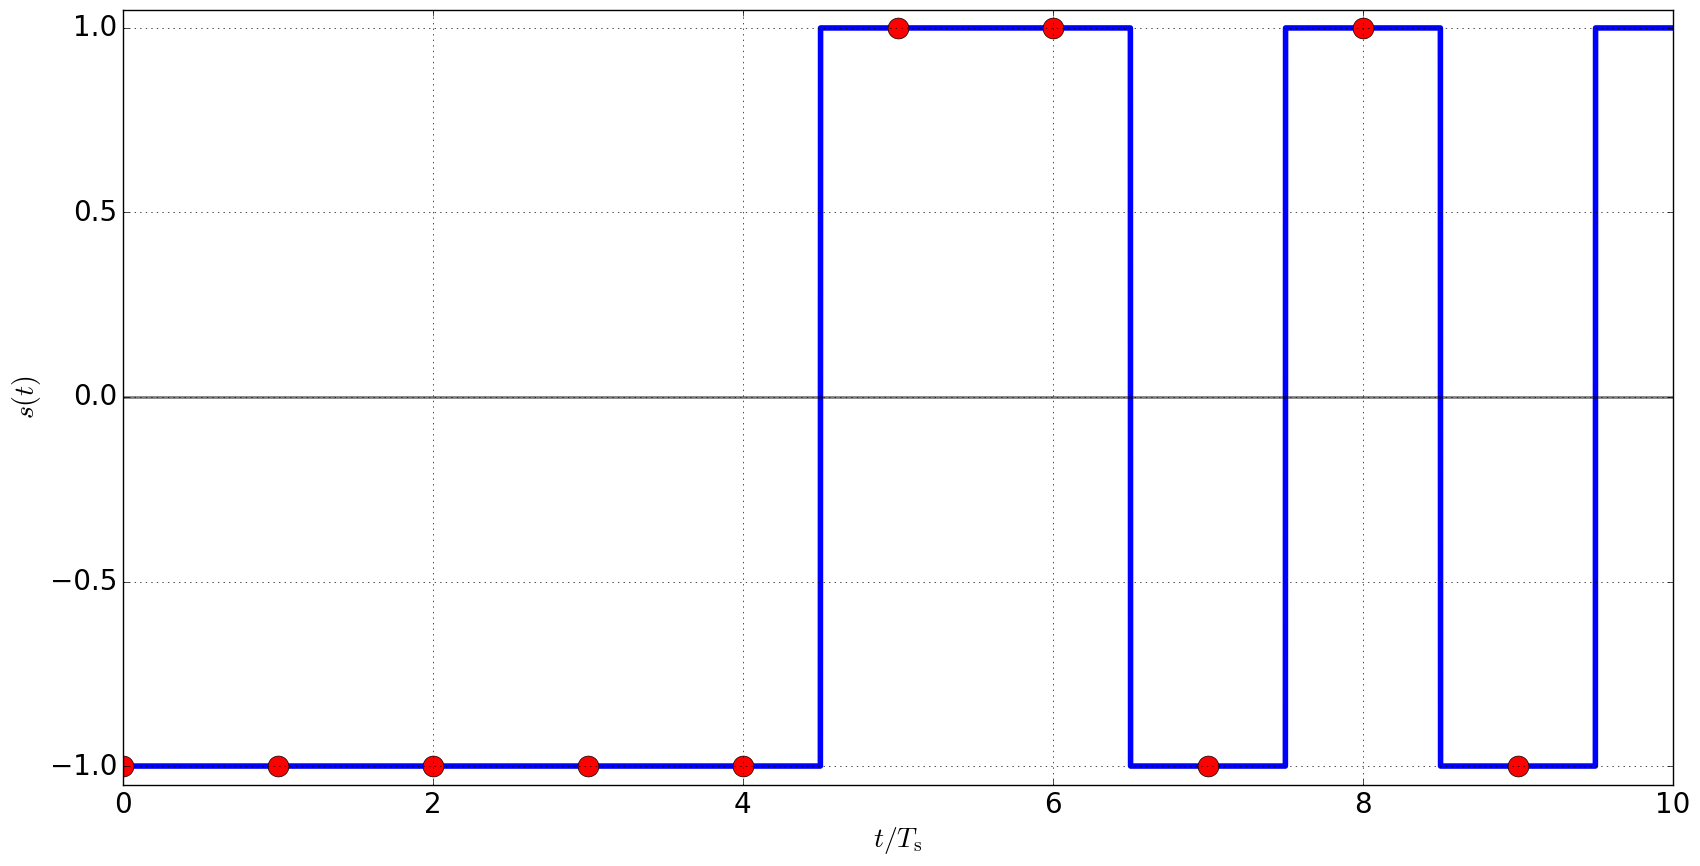

In [6]:
samples_plot_duration = 10*samples_per_symbol
t_plot = delta_t*np.arange(0, samples_plot_duration)
t_symb = t_plot[::samples_per_symbol]
plt.plot(t_plot/Ts, send_signal[:t_plot.shape[0]], lw=4)
plt.plot(t_symb/Ts, send_signal[:t_plot.shape[0]:samples_per_symbol],
         'ro', markersize=15)
plt.axhline(c='k', lw=2, alpha=0.5)
send_lims = (1.05*np.amin(send_signal), 1.05*np.amax(send_signal))
plt.ylim(send_lims)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$s(t)$')
plt.grid()

Durch die Faltung der Impulse im kontinuierlichen Sendesymbolsignal mit der Sendepulsform im Sendefilter wird für jedes Sendesymbol ein mit dem Symbol gewichteter Sendepuls "gesendet", kann also nun auf dem Kanal übertragen werden.

## Kanal

Der Kanal ist der Teil des Übertragungssystems, der meistens nicht einfach angepasst werden kann. Seine Auswirkungen lassen sich durch zwei Effekte beschreiben:

* Eine (in dieser Vorlesung) deterministische lineare Verzerrung des Sendesignals durch Filterung mit einem (in dieser Vorlesung) LTI-System mit der Kanal-Impulsantwort $b(t)$, welche in diesem Notebook wegen $b(t) = \delta(t)$ aber keine Auswirkungen hat.
* Rauschen, das eine zufällige Störung des Signals verursacht. In dieser Vorlesung und auch häufig in der Praxis wird das Rauschen meist als **AWGN-Prozess** (**A**dditive **W**hite **G**aussian **N**oise) modelliert.

Als Empfangssignal (vor dem Empfangsfilter) ergibt sich also:

\begin{align}
    r(t) = s(t) \ast b(t) + n(t) = \sum_{m=-\infty}^{\infty} A(m) h(t - m T_\mathrm{s}) + n(t)
\end{align}

#### Hinweis zur Simulation:
In der Theorie wird mit einem **kontinuierlichen** weißen Rauschen gerechnet, das deshalb auch **unendliche Leistung** besitzt. Das ist in der Simulation wegen den endlich großen Abständen in der zeitlichen Darstellung nicht möglich, denn die maximale Bandbreite ist durch die zeitliche Auflösung vorgegeben. **Diskretes** weißes Rauschen hat immer eine **endliche Leistung**. Deshalb kann trotzdem ein SNR angegeben werden, das auch Einfluss auf die simulierte Übertragung hat.

In [7]:
# Hier wird nur eine impulsfoermige Kanalimpulsantwort betrachtet.
# Deshalb kann auf eine Faltung verzichtet werden und es reicht aus,
# das Sendesignal zu kopieren und ggf. Rauschen hinzuzufuegen.
receive_signal = send_signal.copy()
if add_noise:
    Pn = np.var(send_signal)*10**(-SNR/10)
    noise = np.sqrt(Pn)*np.random.standard_normal(send_signal.shape)
    receive_signal += noise

### Plot des Empfangssignals vor dem Empfangsfilter

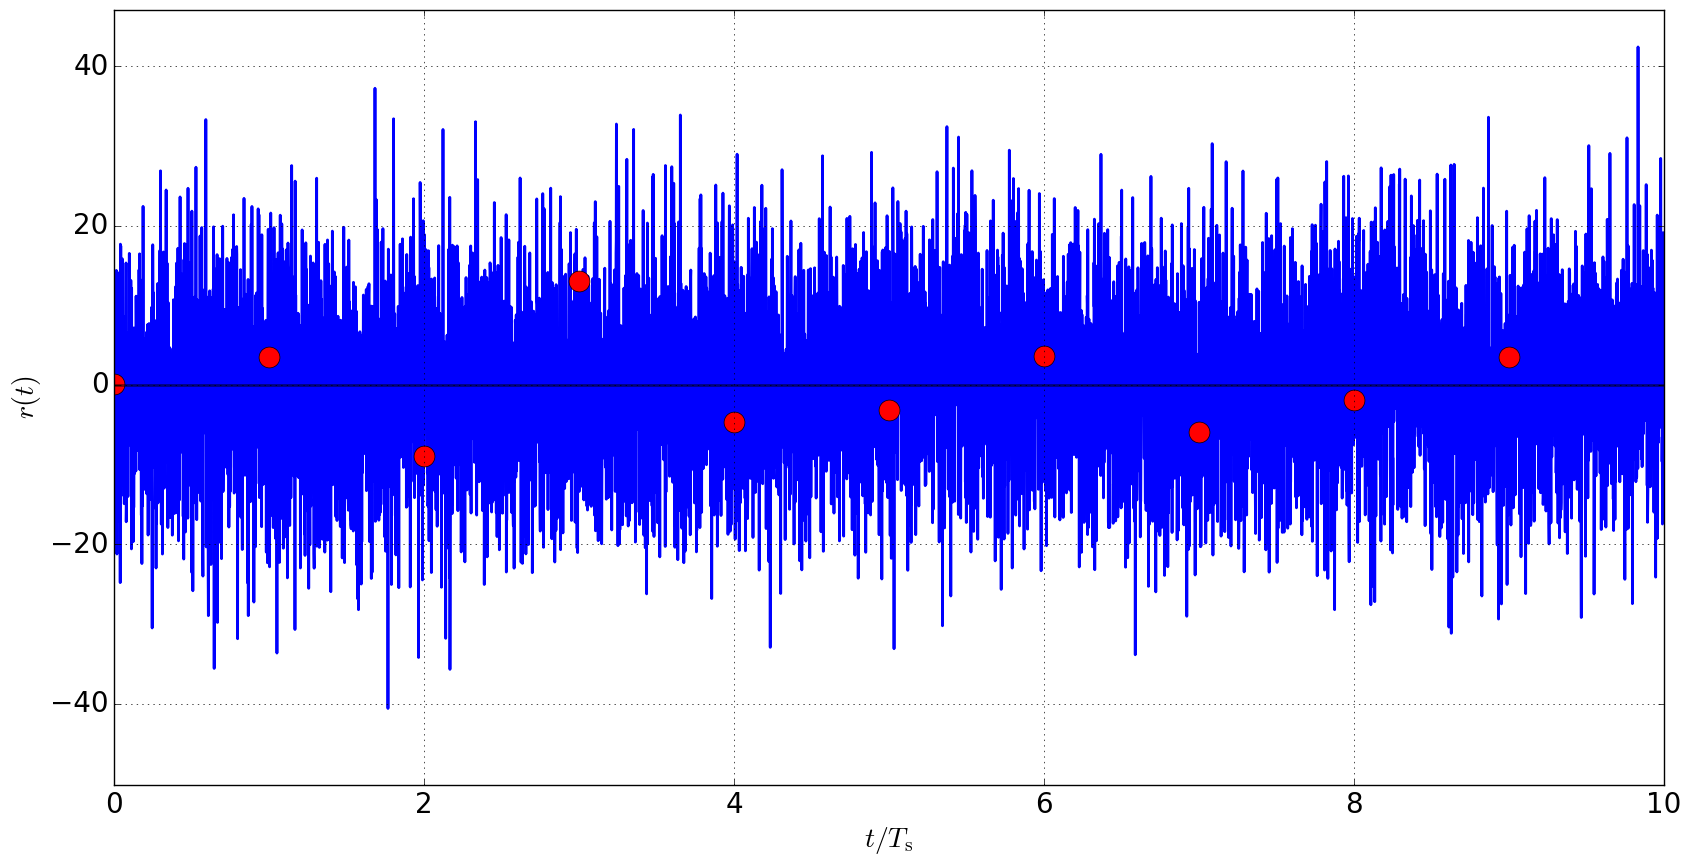

In [8]:
plt.plot(t_plot/Ts, receive_signal[:t_plot.shape[0]], lw=2)
plt.plot(t_symb/Ts, receive_signal[:t_plot.shape[0]:samples_per_symbol],
         'ro', markersize=15)
plt.axhline(c='k', lw=2, alpha=0.5)
rec_lims = (1.05*np.amin(receive_signal), 1.05*np.amax(receive_signal))
plt.ylim(rec_lims)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$r(t)$')
plt.grid()

Hier ist insbesondere die Momentanamplitude des Empfangssignals zu beachten, die abhängig vom SNR wesentlich größer werden kann als die des Sendesignals. Die Momentanwerte des Rauschens können die des Sendesignals also um ein Vielfaches übersteigen.

## Empfänger

### Matched-Filterung

\begin{align}
    q(t) = r(t) \ast f(t) = \sum_{m=-\infty}^{\infty} A(m) p(t - m T_\mathrm{s}) + \tilde{n}(t)
\end{align}

Nach dem Matched-Filter ist die Pulsform jedes zu einem Symbol gehörenden Einzelpulses gleich der **Gesamtpulsform**. Die Entscheidung wird also nicht auf Grundlage der Sendepulsform getroffen; es wird immer der Gesamtpuls betrachtet.

#### Rechteck-Sendepulsformen:
Ist das Sendefilter ein Rechteck, ist das Empfangsfilter wegen der Matched-Filter-Bedingung auch ein Rechteck.   
**Der Effekt ist in diesem Fall sehr intuitiv verständlich**:
* Das Rechteck des Sendefilters sorgt dafür, dass der Momentanmittelwert $\mu_r(t)$ für die Symboldauer vom Sendesymbol abhängt.
* Durch das Rechteck des Empfangsfilter wird über eine Symboldauer integriert.
* Da das Rauschen zu jedem Zeitpunkt mittelwertfrei ist, heben sich die aufintegrierten Abtastwerte im statistischen Mittel auf
* Es verbleit der Anteil, der durch den aufintegrierten skalierten Sendepuls hervorgerufen wird.

Dieser Gedanke lässt sich auch auf andere Pulsformen übertragen, wenn die Filterung im Sinne einer Korrelation verstanden wird. Dies ist am Ende des Notebooks erläutert.

In [9]:
decision_signal = np.convolve(receive_signal, receive_filter, 'same')*delta_t

### Plot des Entscheidungssignals und der Abtastwerte

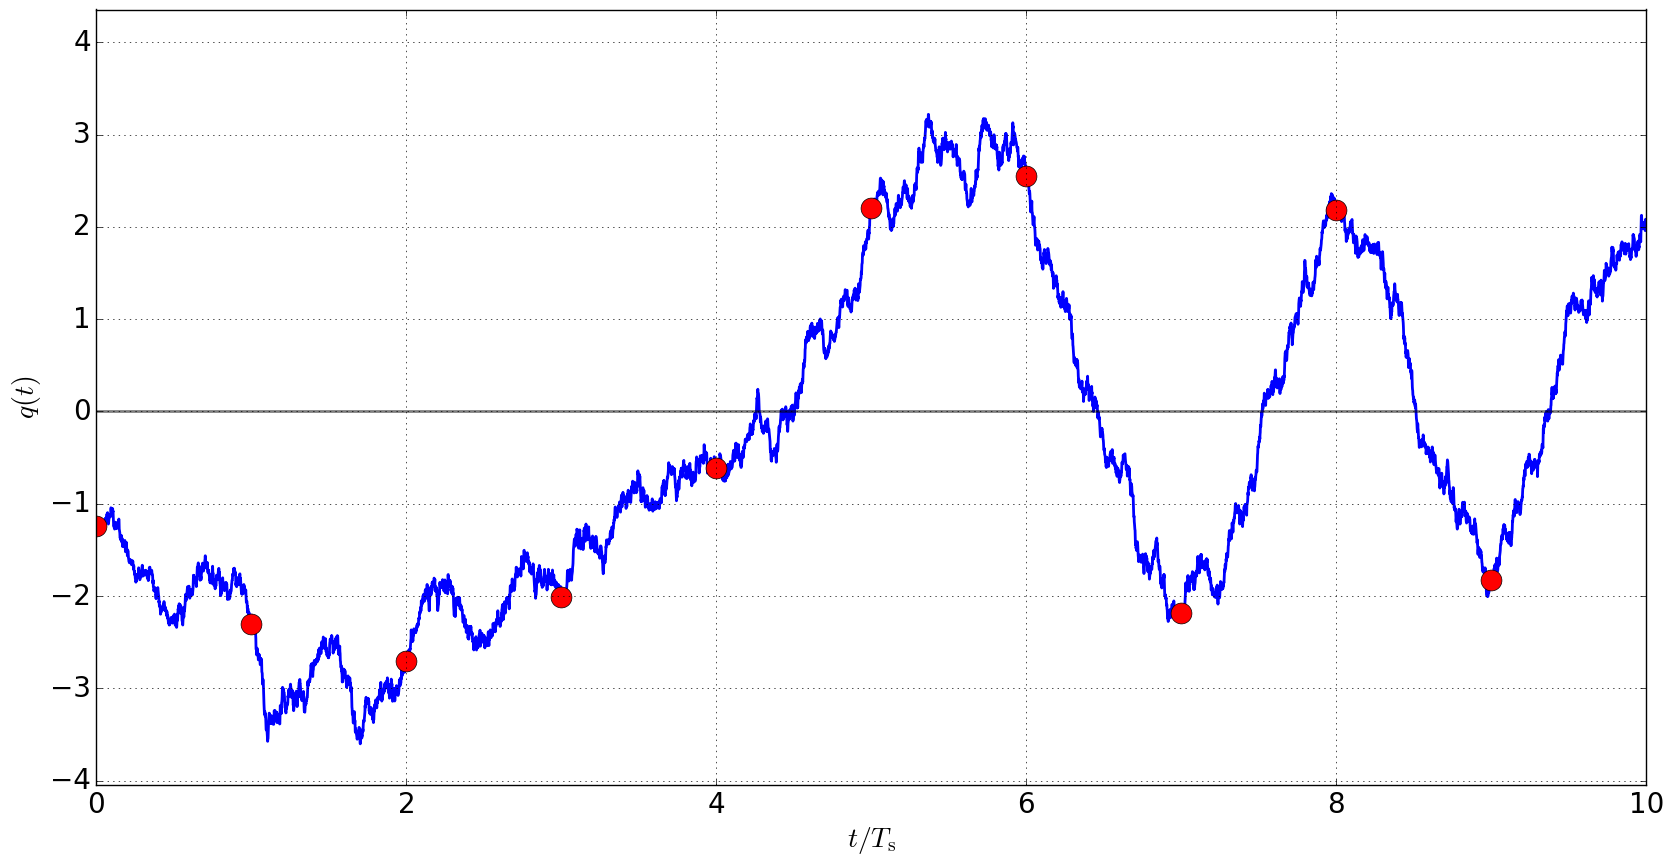

In [10]:
plt.plot(t_plot/Ts, decision_signal[:t_plot.shape[0]], lw=2)
plt.plot(t_symb/Ts, decision_signal[:t_plot.shape[0]:samples_per_symbol],
         'ro', markersize=15)
plt.axhline(c='k', lw=2, alpha=0.5)
dec_lims = (1.05*np.amin(decision_signal), 1.05*np.amax(decision_signal))
plt.ylim(dec_lims)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$q(t)$')
plt.grid()

Hier werden die erstaunlichen Auswirkungen des Matched-Filters sichtbar: Obwohl das Störsignal eine (bei einem SNR von $-20\ \mathrm{dB}$ auf dem Kanal um das **Hundertfache**) höhere Leistung hat als das Nutzsignal, ist das gefilterte Signal dennoch verhältnismäßig eindeutig zu decodieren. Siehe auch das Augendiagramm und die Erläuterungen am Ende.

### Plot des Augendiagramms

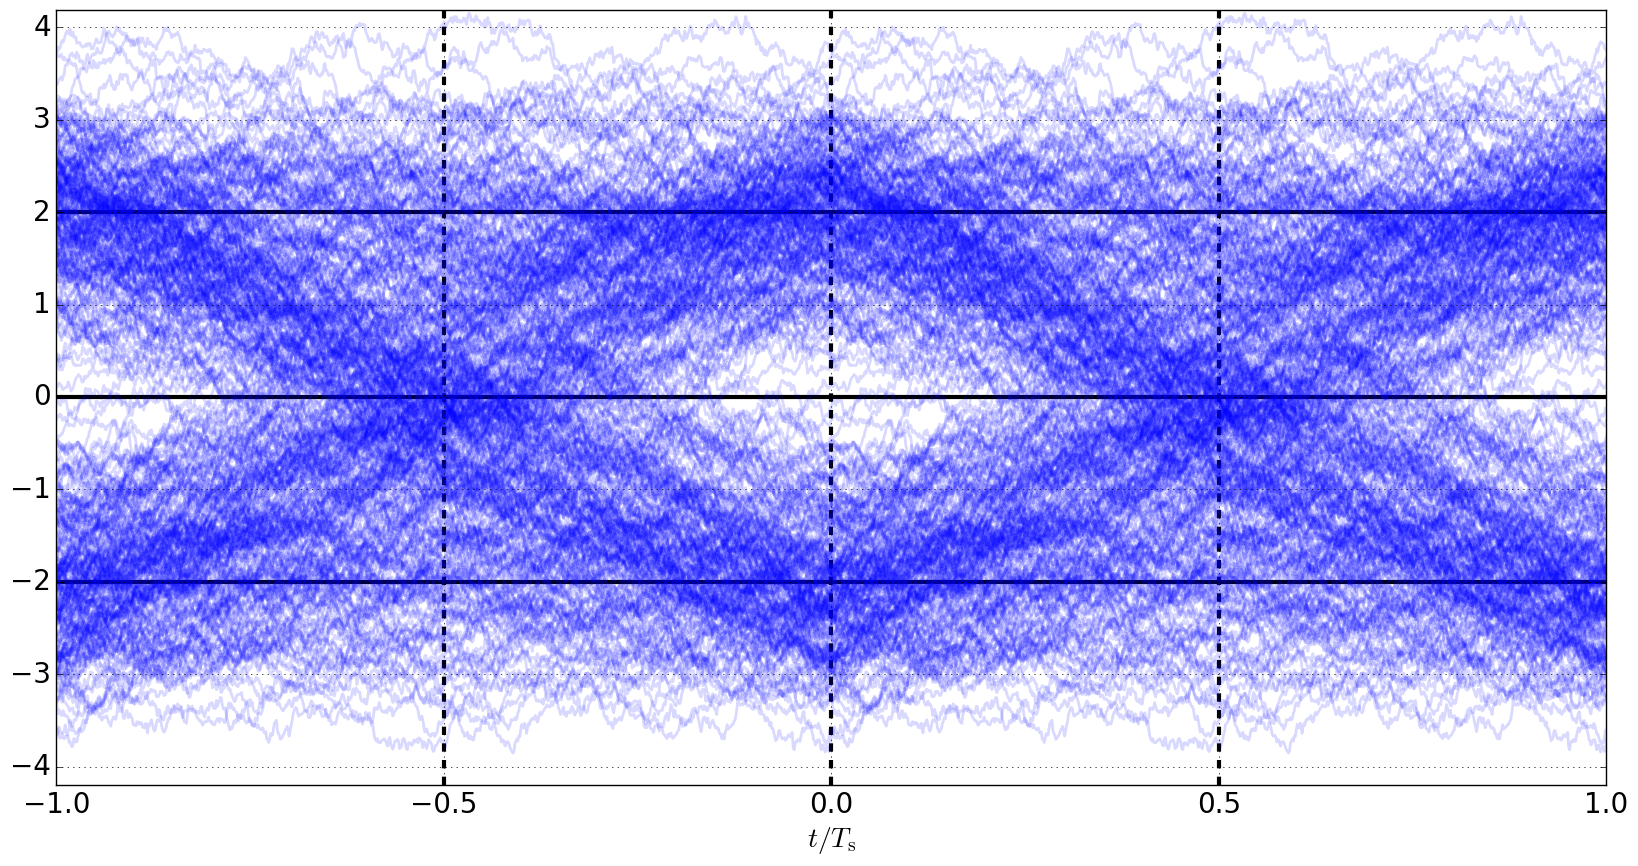

In [11]:
start_symbol_idx = 10
end_symbol_idx = N-10
t_eye = np.linspace(-Ts, Ts, 2*samples_per_symbol)
for n in range(start_symbol_idx, end_symbol_idx):
    decision_signal_current = decision_signal[
        n*samples_per_symbol:(n+2)*samples_per_symbol]
    plt.plot(t_eye/Ts, decision_signal_current, 'b', lw=2, alpha=0.15)
plt.xlim((-1, 1))
q_max = np.amax(decision_signal)
plt.ylim((-1.01*q_max, 1.01*q_max))
plt.vlines([-0.5, 0, 0.5], -1.01*q_max, 1.01*q_max, lw=3, color='k', linestyle='dashed')
plt.hlines([-np.sqrt(Eg), 0, np.sqrt(Eg)], -1, 1, color='k', lw=3)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.grid()

Trotz des schlechten SNRs auf dem Kanal zeigt das Augendiagramm des Entscheidungssignals $q(t)$ vor dem Abtaster ein Auge mit sichtbarer vertikaler Öffnung. Nur sehr selten wird durch das Restrauschen die Entscheidungsgrenze überschritten (in diesem Fall kommt es zu einem Bitfehler).

### SNR vor dem Abtaster zum Abtastzeitpunkt

In [12]:
if add_noise:
    # Nutzsignalanteil des Empfangssignals
    S_q = np.var(np.convolve(send_signal, receive_filter, 'same')*delta_t)
    # Stoersignalanteil
    N_q = np.var(np.convolve(noise, receive_filter, 'same')*delta_t)
    # SNR
    SNR_q = 10*np.log10(S_q/N_q)
    print("SNR = {:3.1f} dB".format(SNR_q))

SNR = 7.3 dB


Das Matched-Filter hat einen hohen Anteil daran, das SNR des Entscheidungssignals zu verbessern:
Die Rauschsignalleistung ist nun (bei einem SNR auf dem Kanal von $-20 \mathrm{dB}$) auf etwa ein Fünftel der Nutzsignalleistung gefallen, statt hundertfach höher zu sein.

### Entscheider und Signalraumdecoder

In [13]:
received_bit_sequence = decision_signal[::samples_per_symbol] > 0
assert(received_bit_sequence.shape[0] == N)

Der Entscheider ist bei BPSK sehr einfach: Das Entscheidungssignal wird nach Abtastung in seinen Maxima mit einem Schwellwert verglichen.
Sind die **Symbole gleich wahrscheinlich** und das Rauschen unabhängig vom gesendeten Symbol, liegt die Entscheidungsschwelle bei BPSK genau in der Mitte zischen den beiden Symbolen, also für mittelwertfreie Symbole immer bei **Null**:

\begin{align}
    \hat{A}(k) = \begin{cases}
        1, & q(k) > 0, \\
        {-}1, & q(k) < 0,
    \end{cases}
\end{align}

Im vorliegenden BPSK-System ist es allerdings einfacher, direkt eine Entscheidung für das übertragene Bit durchzuführen, statt Symbolentscheidungen zu Bitsequenzen zu decodieren. Dadurch werden Entscheidung und Signalraumdecodierung zusammengefasst.

### Bitfehlerrate

In [14]:
# geschaetzte Bitfehlerrate
BER = (received_bit_sequence^bit_sequence).mean()
print("BER = {:1.5f}".format(BER))

BER = 0.00250


#### Hinweis zur Simulation:
Die Bitfehlerrate kann in der Simulation berechnet werden, indem eine elementweise XOR-Operation zwischen der gesendeten und der empfangenen Bitsequenz berechnet wird. Jeder Fehler erzeugt eine 1 in der resultierenden Sequenz.
Durch Summation und Teilen durch die Anzahl der gesendeten Bits bzw. äquivalent durch Berechnung des arithmetischen Mittels ergibt sich ein Schätzwert für die Bitfehlerrate.

Die Auswirkung des Matched-Filters zeigt sich auch in der Bitfehlerrate $P_\mathrm{b} = \mathrm{BER}$:
Trotz starken Rauschens ist (bei einem SNR auf dem Kanal von $20 \mathrm{dB}$) von 400 übertragenen Bit nur ein einziges fehlerhaft (zumindest in der durchgeführten Simulation). Dies lässt sich durch Erhöhung der Sendeleistung natürlich noch weiter reduzieren, denn bei BPSK gilt:

\begin{align}
    P_\mathrm{b} = P_\mathrm{s} = Q\left(\sqrt{\frac{2 E_\mathrm{s}}{N_0}} \right) = \left(\sqrt{\mathrm{SNR}} \right) = Q\left(\sqrt{\frac{S_q}{N_q}} \right)
\end{align}

## Zusatz: Matched-Filterung etwas anders erklärt

Für den optimalen Empfänger muss laut Vorlesung gelten:

\begin{align}
    f(t) \overset{!}{=} K \cdot h(t_0 - t) \text{  mit   } h(t) = g(t) \ast b(t)
\end{align}

Anschaulich kann man sich dies so vorstellen:  
Das Sendesignal besteht aus einer additiven Überlagerung von mit den Symbolen skalierten, zeitverschobenen Kopien des Sendepulses:

\begin{align}
    s(t) = \sum_{m=-\infty}^{\infty} A(m) g(t -mT_\mathrm{s})
\end{align}

Der Kanal verzerrt das Sendesignal mit einer (hier als **bekannt** angenommenen) Impulsantwort:

\begin{align}
    r(t) = s(t) \ast b(t) + n(t)  = \sum_{m=-\infty}^{\infty} A(m) h(t-mT_\mathrm{s}) + n(t)
\end{align}

**Damit ist die Signalform h(t) der Pulse im erwarteten Empfangssignal bekannt**.
Unbekannt und störend ist aber das Rauschen, das bei der Übertragung hinzugefügt wird.
Um eine **bekannte Signalform h(t) in einem gegebenen Signal** zu finden, kann man die **Kreuzkorrelation (für Energiesignale)** verwenden, die sich durch eine Faltung (und damit durch eine Filterung) darstellen lässt:

\begin{align}
    \varphi^\mathrm{E}_{hr}(t) &= h(-t) \ast r(t) 
    = \int_{-\infty}^{\infty} h(-\tau) r(t - \tau) \mathrm{d}\tau 
    = \int_{-\infty}^{\infty} r(\tau) h(-(t - \tau)) \mathrm{d}\tau
\end{align}

Wenn $r(t) = A(0) \cdot (g(t)\ast b(t)) = A(0) h(t)$ gesetzt wird, lässt sich $f(t) = h(-t)$ identifizieren. **Die zeitliche Inversion ist also notwenig, damit durch die Faltung eine Korrelation berechnet wird**.  
Der Optimale Abtastzeitpunkt $t_0$ lässt sich durch Umformen bestimmen, wenn das Rauschen zu Null gewählt wird:

\begin{align}
    \left. \varphi^\mathrm{E}_{hr}(t_0) \right|_{n(t) = 0} &= \int_{-\infty}^{\infty} r(\tau) h(-(t - \tau)) \mathrm{d}\tau \\
    &= \int_{-\infty}^{\infty} A(0) h(\tau) h(-(t - \tau)) \mathrm{d}\tau  \\
    &=  A(0) \int_{-\infty}^{\infty} h(\tau) h(-(t - \tau)) \mathrm{d}\tau  \\
    &=  A(0) \int_{-\infty}^{\infty} h(\tau) h(-(t_0) + \tau)) \mathrm{d}\tau \\
    &= A(m) \varphi^\mathrm{E}_{hh}(-(t_0))
\end{align}

Das Vorzeichen vor $t_0$ spielt wegen der geraden AKF keine  Rolle. **Das Maximum der AKF ist bei $t_0 = 0$. Dies ist deshalb auch der ideale Abtastzeitpunkt.**   
Durch **Einführung einer Verzögerung und gleichzeitiger Verschiebung des Abtastzeitpunktes** um diese Verzögerung kann aber in der Praxis sichergestellt werden, dass **sowohl Sende- als auch Empfangsfilter kausale Systeme** sind. Auch eine Skalierung ist erlaubt, da Nutzsignalanteil und Rauschen in gleicher Weise skaliert werden. So gelangt man zur allgemeineren Definition des Matched-Filters oben.  
Außerdem ist folgende Betrachtungsweise möglich:

\begin{align}
    \varphi^\mathrm{E}_{hr}(0) = \int_{-\infty}^{\infty} h(\tau) r(\tau) \mathrm{d}\tau
\end{align}

Das heißt, **das Matched-Filter berechnet zum Abtastzeitpunkt das Skalarprodukt zwischen Empfangssignal und erwarteter Signalform**.  
Das bisher vernachlässigte Rauschen hat zu jedem Zeitpunkt wenig Ähnlichkeit mit der erwarteten Pulsform und wird deshalb unterdrückt.